# Panel estimation of wildifire probability 

In [1]:
from tsraster.prep import combine_extracted_features, combine_target_rasters, wide_to_long_target_features,unmask_df,panel_lag_1
from tsraster.calculate import checkRelevance2, calculateFeatures

from numpy import NaN,isnan
from pathlib import Path 
import os
import pandas as pd

import tsraster.prep  as tr
import tsraster.model  as md

import rasterio
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, cohen_kappa_score
from sklearn.ensemble import GradientBoostingClassifier

### Features Extraction at Scale

In [2]:
fc_parameters = {
	    "mean": None,
	    "maximum": None,
	    "median":None}

p = Path('../Data/Examples/Panel_Example/Climate/')
folders = [str(x) for x in p.glob('*/*') if x.is_dir() and '_features' not in str(x) and 'Fire' not in str(x) ]
folders

['..\\Data\\Examples\\Panel_Example\\Climate\\2006_2010\\cwd',
 '..\\Data\\Examples\\Panel_Example\\Climate\\2006_2010\\ppt',
 '..\\Data\\Examples\\Panel_Example\\Climate\\2011_2015\\cwd',
 '..\\Data\\Examples\\Panel_Example\\Climate\\2011_2015\\ppt']

In [12]:
for folder in folders:
    if not os.listdir(folder):
        print("Directory is empty")
    else:    
        print("Directory is not empty")
        print(folder)
        ts_features = calculateFeatures(folder,
                                        parameters=fc_parameters,
                                        reset_df=True,
                                        tiff_output=False,
                                        raster_mask =  r"../Data/Examples/buffer/StatePoly_buf.tif",
                                        workers = 1)
        print(ts_features.describe())
        del ts_features

Directory is not empty
..\Data\Examples\Panel_Example\Climate\2006_2010\cwd
df: ..\Data\Examples\Panel_Example\Climate\2006_2010\cwd\my_df.csv


Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.46s/it]


features:..\Data\Examples\Panel_Example\Climate\2006_2010\cwd_features\extracted_features.csv
       cwd__maximum     cwd__mean   cwd__median
count  1.137669e+06  1.137669e+06  1.137669e+06
mean  -6.321948e+03 -6.361746e+03 -6.369084e+03
std    4.893647e+03  4.840688e+03  4.830975e+03
min   -9.999000e+03 -9.999000e+03 -9.999000e+03
25%   -9.999000e+03 -9.999000e+03 -9.999000e+03
50%   -9.999000e+03 -9.999000e+03 -9.999000e+03
75%    1.838448e+02  6.138217e+01  1.257800e+01
max    2.327495e+02  1.318143e+02  1.334538e+02
Directory is not empty
..\Data\Examples\Panel_Example\Climate\2006_2010\ppt
df: ..\Data\Examples\Panel_Example\Climate\2006_2010\ppt\my_df.csv


Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.89s/it]


features:..\Data\Examples\Panel_Example\Climate\2006_2010\ppt_features\extracted_features.csv
       ppt__maximum     ppt__mean   ppt__median
count  1.137669e+06  1.137669e+06  1.137669e+06
mean  -6.318338e+03 -6.375807e+03 -6.383758e+03
std    4.899379e+03  4.822003e+03  4.811385e+03
min   -9.999000e+03 -9.999000e+03 -9.999000e+03
25%   -9.999000e+03 -9.999000e+03 -9.999000e+03
50%   -9.999000e+03 -9.999000e+03 -9.999000e+03
75%    7.860650e+01  1.487717e+01  4.968500e+00
max    1.191274e+03  3.167586e+02  2.474300e+02
Directory is not empty
..\Data\Examples\Panel_Example\Climate\2011_2015\cwd
df: ..\Data\Examples\Panel_Example\Climate\2011_2015\cwd\my_df.csv


Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00, 10.28s/it]


features:..\Data\Examples\Panel_Example\Climate\2011_2015\cwd_features\extracted_features.csv
       cwd__maximum     cwd__mean   cwd__median
count  1.137669e+06  1.137669e+06  1.137669e+06
mean  -6.322409e+03 -6.360048e+03 -6.362518e+03
std    4.893033e+03  4.842955e+03  4.839713e+03
min   -9.999000e+03 -9.999000e+03 -9.999000e+03
25%   -9.999000e+03 -9.999000e+03 -9.999000e+03
50%   -9.999000e+03 -9.999000e+03 -9.999000e+03
75%    1.842680e+02  6.424258e+01  4.230175e+01
max    2.329300e+02  1.402930e+02  1.575240e+02
Directory is not empty
..\Data\Examples\Panel_Example\Climate\2011_2015\ppt
df: ..\Data\Examples\Panel_Example\Climate\2011_2015\ppt\my_df.csv


Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.52s/it]


features:..\Data\Examples\Panel_Example\Climate\2011_2015\ppt_features\extracted_features.csv
       ppt__maximum     ppt__mean   ppt__median
count  1.137669e+06  1.137669e+06  1.137669e+06
mean  -6.317016e+03 -6.376843e+03 -6.383711e+03
std    4.901381e+03  4.820616e+03  4.811441e+03
min   -9.999000e+03 -9.999000e+03 -9.999000e+03
25%   -9.999000e+03 -9.999000e+03 -9.999000e+03
50%   -9.999000e+03 -9.999000e+03 -9.999000e+03
75%    7.883900e+01  1.455392e+01  6.439800e+00
max    1.559048e+03  2.847197e+02  2.021816e+02


### Organize data

* Climate_feature_subset_train
    * 2001_2005
        * aet_features
            * extracted_features.csv
            * ...
        * ppt_features
            * extracted_features.csv
            * ...        
    * 2006_2010
        * aet_features
            * extracted_features.csv
            * ...
        * ppt_features
            * extracted_features.csv
            * ...  
    * 2011_2015

### append all features to one dataframe

In [3]:

path = r'../Data/Examples/Panel_Example/Climate/'

concatenated_attribute_df = combine_extracted_features(path,write_out=False)


Combining folder year names ['20062010', '20062010', '20112015', '20112015']


C:\Users\mmann\AppData\Local\Continuum\anaconda2\envs\ts-rasterv2\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
concatenated_attribute_df.head()

,cwd__maximum-20062010,cwd__mean-20062010,cwd__median-20062010,ppt__maximum-20062010,ppt__mean-20062010,ppt__median-20062010,cwd__maximum-20112015,cwd__mean-20112015,cwd__median-20112015,ppt__maximum-20112015,ppt__mean-20112015,ppt__median-20112015
pixel_id,,,,,,,,,,,,
0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
1,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
2,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
3,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
4,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0


collect multitple years of Y (target) data

In [5]:
path = r"../Data/Examples/Panel_Example/Fire/"
target_file_prefix = 'fire_'

concatenated_target_df = combine_target_rasters(path,
                                                target_file_prefix,
                                                write_out=False)

In [6]:
concatenated_target_df.head()

,Y-20062010,Y-20112015
pixel_id,,
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


mask both the attribute data and targets 

In [7]:
raster_mask =u"../Data/Examples/buffer/StatePoly_buf.tif"
original_df = [concatenated_attribute_df, concatenated_target_df]

mask_attributes_df, mask_target_df = tr.mask_df(raster_mask, 
                                                original_df,  
                                                missing_value=-9999,
                                                reset_index = False)

In [8]:
mask_attributes_df.head()

,cwd__maximum-20062010,cwd__mean-20062010,cwd__median-20062010,ppt__maximum-20062010,ppt__mean-20062010,ppt__median-20062010,cwd__maximum-20112015,cwd__mean-20112015,cwd__median-20112015,ppt__maximum-20112015,ppt__mean-20112015,ppt__median-20112015
pixel_id,,,,,,,,,,,,
134588,95.193573,10.808438,0.0,535.173157,154.437119,116.529739,84.842857,16.329674,0.0000,565.594971,150.687866,108.165001
134589,114.003502,20.163677,0.0,552.677979,161.583511,122.655746,95.689499,25.205521,0.0000,589.078491,156.253983,111.509003
134590,157.690506,24.496553,0.0,564.724487,166.094742,126.713501,132.104996,26.933245,0.0000,578.199524,152.994583,109.597748
134591,160.140396,25.144434,0.0,580.050781,172.390976,132.294403,135.035995,26.979912,0.0000,588.890015,155.064163,109.506195
134592,162.972397,26.338125,0.0,600.773621,179.457764,138.405792,138.880005,27.230467,0.2344,631.367188,165.473877,115.161003


In [9]:
mask_target_df.head()

,Y-20062010,Y-20112015
pixel_id,,
134588,0,0
134589,0,0
134590,0,0
134591,0,0
134592,0,0


switch panel data from wide to long format

In [10]:
target_ln, features_ln = wide_to_long_target_features(target = mask_target_df,
                                                      features = mask_attributes_df,
                                                      sep='-')

converted to long, indexes match


Show size and repeated obs by pixel cell

In [11]:
features_ln.sort_index().head(10)

cwd__maximum  ppt__maximum  ppt__median   ppt__mean  \
pixel_id time                                                            
134588   20062010     95.193573    535.173157   116.529739  154.437119   
         20112015     84.842857    565.594971   108.165001  150.687866   
134589   20062010    114.003502    552.677979   122.655746  161.583511   
         20112015     95.689499    589.078491   111.509003  156.253983   
134590   20062010    157.690506    564.724487   126.713501  166.094742   
         20112015    132.104996    578.199524   109.597748  152.994583   
134591   20062010    160.140396    580.050781   132.294403  172.390976   
         20112015    135.035995    588.890015   109.506195  155.064163   
134592   20062010    162.972397    600.773621   138.405792  179.457764   
         20112015    138.880005    631.367188   115.161003  165.473877   

                   cwd__mean  cwd__median  
pixel_id time                              
134588   20062010  10.808438       0.0000  
         20112015  16.329674       0.0000  
134589   20062010  20.163677       0.0000  
         20112015  25.205521       0.0000  
134590   20062010  24.496553       0.0000  
         20112015  26.933245       0.0000  
134591   20062010  25.144434       0.0000  
         20112015  26.979912       0.0000  
134592   20062010  26.338125       0.0000  
         20112015  27.230467       0.2344

In [12]:
target_ln.sort_index().head(10)

Y
pixel_id time       
134588   20062010  0
         20112015  0
134589   20062010  0
         20112015  0
134590   20062010  0
         20112015  0
134591   20062010  0
         20112015  0
134592   20062010  0
         20112015  0

### add temporal lagged variables 

In [13]:

lag_vars = ['ppt__median',
 'cwd__mean',
 'cwd__maximum']    


features_ln = panel_lag_1(features_ln, 
                          col_names=lag_vars, 
                          group_by_index ='pixel_id')



# ADDING two copies of cwd_mean_1

adding a temporal lag implies that one time period will be lost

In [14]:
features_ln.head()

,,cwd__maximum,ppt__maximum,ppt__median,ppt__mean,cwd__mean,cwd__median,cwd__mean_1,cwd__maximum_1,ppt__median_1
pixel_id,time,,,,,,,,,
134588,20112015,84.842857,565.594971,108.165001,150.687866,16.329674,0.0000,10.808438,95.193573,116.529739
134589,20112015,95.689499,589.078491,111.509003,156.253983,25.205521,0.0000,20.163677,114.003502,122.655746
134590,20112015,132.104996,578.199524,109.597748,152.994583,26.933245,0.0000,24.496553,157.690506,126.713501
134591,20112015,135.035995,588.890015,109.506195,155.064163,26.979912,0.0000,25.144434,160.140396,132.294403
134592,20112015,138.880005,631.367188,115.161003,165.473877,27.230467,0.2344,26.338125,162.972397,138.405792


join and test train split yX data, define groups of independent objects by pixel id

although not case here, you will typically have multiple observations from a single pixel, therefore it is important to group by pixel_id index, this ensures that each pixel is only included in either the training or testing data

In [15]:
obj = [target_ln,features_ln]

X_train, X_test, y_train, y_test = md.get_data(obj,
                                            stratify=True,
                                            test_size=0.9,
                                            scale=False,
                                            groups =  features_ln.index.get_level_values('pixel_id') )

input should be csv or pandas dataframe with yX, or [y,X]
reading in list concat on common index, inner join
ERROR: need to figure out groups with stratification by y


### Filter variables and train model

Find relevant variables and combine Y and X data

In [16]:
relevant_vars, X_train_relevant = checkRelevance2(x=X_train,
                                                  y=y_train,
                                                  fdr_level=0.01) 
print(relevant_vars)

X_test_relevant = X_test[X_train_relevant.columns]

                       feature  type  p_value  relevant
feature                                                
cwd__maximum      cwd__maximum  real      0.0      True
ppt__maximum      ppt__maximum  real      0.0      True
ppt__median        ppt__median  real      0.0      True
ppt__mean            ppt__mean  real      0.0      True
cwd__mean            cwd__mean  real      0.0      True
cwd__median        cwd__median  real      0.0      True
cwd__mean_1        cwd__mean_1  real      0.0      True
cwd__maximum_1  cwd__maximum_1  real      0.0      True
ppt__median_1    ppt__median_1  real      0.0      True


train a gradient booster classifier 

In [17]:
clf = GradientBoostingClassifier(n_estimators=400, learning_rate=0.1,
                                 max_depth=2, random_state=0)\
                                .fit(X_train[X_train_relevant.columns], y_train)

In [18]:
X_train_relevant.columns

Index(['cwd__maximum', 'ppt__maximum', 'ppt__median', 'ppt__mean', 'cwd__mean',
       'cwd__median', 'cwd__mean_1', 'cwd__maximum_1', 'ppt__median_1'],
      dtype='object')

In [19]:
predict_test = clf.predict(X=X_test[X_train_relevant.columns])

test_acc = accuracy_score(y_test, predict_test)
kappa = cohen_kappa_score(y_test, predict_test)
confusion = confusion_matrix(y_test, predict_test)

print('Testing accuracy:',test_acc)
print('Testing Kappa: ',kappa)
print('Testing Conf: ')
print(confusion)

Testing accuracy: 0.9720368295415793
Testing Kappa:  0.014021813029466368
Testing Conf: 
[[79795     7]
 [ 2289    17]]


Look at feature importance

In [20]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_test_relevant.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
 
print(feature_importances.head(10))
feature_importances.shape

                importance
cwd__mean         0.208788
ppt__median_1     0.177789
ppt__maximum      0.165352
ppt__mean         0.142789
ppt__median       0.115897
cwd__maximum      0.068204
cwd__maximum_1    0.045207
cwd__mean_1       0.043384
cwd__median       0.032589


(9, 1)

predict to all observations in panel
get predicted class and probability of class

In [21]:
print(features_ln[X_train_relevant.columns].shape)
print(X_test[X_train_relevant.columns].shape)
print(features_ln[X_train_relevant.columns].columns)
print(X_test[X_train_relevant.columns].columns)

(410537, 9)
(82108, 9)
Index(['cwd__maximum', 'ppt__maximum', 'ppt__median', 'ppt__mean', 'cwd__mean',
       'cwd__median', 'cwd__mean_1', 'cwd__maximum_1', 'ppt__median_1'],
      dtype='object')
Index(['cwd__maximum', 'ppt__maximum', 'ppt__median', 'ppt__mean', 'cwd__mean',
       'cwd__median', 'cwd__mean_1', 'cwd__maximum_1', 'ppt__median_1'],
      dtype='object')


In [22]:
concatenated_df_predict = md.model_predict(model = clf,
                                            new_X = features_ln[X_train_relevant.columns])

concatenated_df_prob =  md.model_predict_prob(model = clf,
                                        new_X = features_ln[X_train_relevant.columns])

isolate one 5 year period for mapping 


In [25]:
concatenated_df_prob_2011 = concatenated_df_prob.query('time == "20112015" ')

print(concatenated_df_prob_2011.describe())

                   0              1
count  410537.000000  410537.000000
mean        0.972245       0.027755
std         0.047635       0.047635
min         0.000160       0.000091
25%         0.967403       0.002601
50%         0.990246       0.009754
75%         0.997399       0.032597
max         0.999909       0.999840


unmask values 

In [46]:
unmask_concatenated_df_prob_2011 = unmask_df(original_df = concatenated_attribute_df, 
                                                mask_df_output = concatenated_df_prob_2011)
unmask_concatenated_df_prob_2011.head()

,time,0,1,value
pixel_id,,,,
0,-9999,-9999.0,-9999.0,-9999
1,-9999,-9999.0,-9999.0,-9999
2,-9999,-9999.0,-9999.0,-9999
3,-9999,-9999.0,-9999.0,-9999
4,-9999,-9999.0,-9999.0,-9999


In [43]:
unmask_concatenated_df_prob_2011[1].describe()

count    1.137669e+06
mean    -6.390770e+03
std      4.802029e+03
min     -9.999000e+03
25%     -9.999000e+03
50%     -9.999000e+03
75%      3.915681e-03
max      9.998403e-01
Name: 1, dtype: float64

In [47]:
# keep only class prob of fire event 
prob_2011 = unmask_concatenated_df_prob_2011[1]  # column is named 1
prob_2011[prob_2011 == -9999 ]= NaN 

prob_2011.describe()

C:\Users\mmann\AppData\Local\Continuum\anaconda2\envs\ts-rasterv2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


count    410537.000000
mean          0.027755
std           0.047635
min           0.000091
25%           0.002601
50%           0.009754
75%           0.032597
max           0.999840
Name: 1, dtype: float64

### rasterize and plot prediction

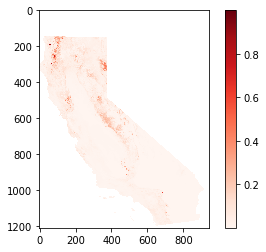

In [48]:
raster_ex = "F:/5year/aet/aet-201201.tif"
ex_row, ex_cols =  rasterio.open(raster_ex).shape

f2Array = prob_2011.values.reshape(ex_row, ex_cols)
 # Plot the grid

plt.imshow(f2Array)
plt.set_cmap("Reds")
plt.colorbar( )
plt.show()

compare to actual

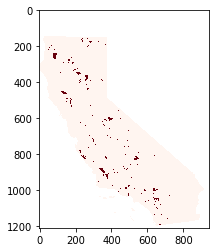

In [49]:

path = r"G:\Fire_target_train\fire_1996_2000.tif"
image_name = tr.image_names(path)
rasters = tr.image_to_array(path)[:,:,0]
rasters[isnan(f2Array)] = NaN

plt.imshow(rasters)
plt.set_cmap("Reds")
plt.show()
